In [41]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import rioxarray as rxr

import joblib
import lightgbm as lgb

from os import listdir
from os.path import join, getsize

import matplotlib.pyplot as plt

from PM_eq import penman_monteith
import config

In [2]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
import psutil
ram = psutil.virtual_memory()
print(f"Available: {ram.available / 1e9:.2f} GB")

Available: 1947.90 GB


In [4]:
startYear, endYear = 2019, 2024
bbox=[-104.,   36.,  -82.,   49.]
final_model = joblib.load(f'../models/lightgbm_model.txt')

# Inspect missing days
- [x] Check for missing days;
- [x] Check for invalid files (too light files);

In [5]:
sources = ['ERA5', 'MODIS', 'MODIS_Clouds', 'MCD']
size_thresholds = {'ERA5':1, 'MODIS':400}
files2derive = {'ERA5': [], 'MODIS': []}
for source in sources[:1]:
    for year in range(startYear, endYear+1):
        if year%4==0:
            days = 366
        else:
            days = 365
        files  = listdir(f'./data/{source}/{year}')
        days = list(range(1, days+1))
        for d in days:
            if f'{source}_{year}_{d}.tif' not in files:
                print(f'Absent: {source}_{year}_{d}.tif')
                files2derive[source].append(f'{source}_{year}_{d}.tif')
            else:
                size = getsize(f'./data/{source}/{year}/{source}_{year}_{d}.tif')
                size_mb = size / (1024 * 1024)
                
                if size_mb<size_thresholds[source]:
                    print(f'Invalid ({size} Mb): {source}_{year}_{d}.tif')
                    files2derive[source].append(f'{source}_{year}_{d}.tif')

Absent: ERA5_2022_93.tif
Absent: ERA5_2022_94.tif
Absent: ERA5_2022_95.tif
Absent: ERA5_2022_96.tif
Absent: ERA5_2022_97.tif
Absent: ERA5_2022_98.tif
Absent: ERA5_2022_99.tif


# Generate Data

TODO: derive MOD CLOUDMASKS!

TODO: derive MCD12Q1 IGBP!

In [6]:
year = 2018

In [7]:
if year%4==0:
    days = 366
else:
    days = 365
#days = list(range(1, days+1))
days = list(range(364, days+1))

In [8]:
def slice_ds(ds):
    return ds.sel(
            x=slice(bbox[0], bbox[2]),
            y=slice(bbox[3], bbox[1]),  
        )

In [58]:
ETs = []
for day in days:
    mcd_year = year if len(days)>=30 else year+1
    prev_year_days = 365 if (year-1)%4!=0 else 366
    startDay = day - 29 if day>=30 else day - 29 + prev_year_days #taking the timestamps from the previous year

    mcd_fname = f'./data/MCD/MCD_{mcd_year}_1.tif' #2024 is a copy of 2023 since it's not released yet
    mcd = rxr.open_rasterio(mcd_fname, mask_and_scale=True).rio.reproject("EPSG:4326")
    mcd = slice_ds(mcd)
    
    arrays = []
    for stamp in range(startDay, day+1):
        era_fname = f'./data/ERA5/{year}/ERA5_{year}_{stamp}.tif'
        modis_fname = f'./data/MODIS/{year}/MODIS_{year}_{stamp}.tif'
        modis_clouds_fname = f'./data/MODIS Clouds/{year}/MODIS_Clouds_{year}_{stamp}.tif'
        
        era = rxr.open_rasterio(era_fname, mask_and_scale=True)
        mod = rxr.open_rasterio(modis_fname, mask_and_scale=True).rio.reproject("EPSG:4326")
        mod_clouds = rxr.open_rasterio(modis_clouds_fname, mask_and_scale=True).rio.reproject("EPSG:4326")
        mod = slice_ds(mod)
        mod_clouds = slice_ds(mod_clouds)
    
        era_res = era.rio.reproject_match(mod, resampling=rasterio.enums.Resampling.bilinear) #biliearly resampling ERA to the MODIS's grid
        era_res = slice_ds(era_res)
        
        era_vars = list(era_res.attrs['long_name'])
        mod_vars = list(mod.attrs['long_name']) + ['Clouds']
        var_names = era_vars + mod_vars + ['IGBP']

        array = np.concatenate([era_res.values.astype(np.float32), mod.values.astype(np.float32), 
                                mod_clouds.values.astype(int), mcd.values.astype(int)], axis=0) #shape: (19, 3009, 6749)
        arrays.append(array)
        print(f'Stamp {stamp+1}/{day+1}', f'Memory: {np.array(arrays).astype(np.float32).nbytes / 1e9}')
    
    arrays = np.array(arrays)
    df = compute_features(arrays, era_vars, mod_vars, stamp, year, mod.x.values, mod.y.values)
    y_pred = final_model.predict(df)
    Lv = 2.501 - 0.00237 * df['temperature_2m']
    ET0 = y_pred/(Lv * 1e6/(24*60*60))
    ET0 = ET0.values.reshape(1468, 2514)
    ETs.append(ET0)

Stamp 336/365 Memory: 0.310006368
Stamp 337/365 Memory: 0.620012736
Stamp 338/365 Memory: 0.930019104
Stamp 339/365 Memory: 1.240025472
Stamp 340/365 Memory: 1.55003184
Stamp 341/365 Memory: 1.860038208
Stamp 342/365 Memory: 2.170044576
Stamp 343/365 Memory: 2.480050944
Stamp 344/365 Memory: 2.790057312
Stamp 345/365 Memory: 3.10006368
Stamp 346/365 Memory: 3.410070048
Stamp 347/365 Memory: 3.720076416
Stamp 348/365 Memory: 4.030082784
Stamp 349/365 Memory: 4.340089152
Stamp 350/365 Memory: 4.65009552
Stamp 351/365 Memory: 4.960101888
Stamp 352/365 Memory: 5.270108256
Stamp 353/365 Memory: 5.580114624
Stamp 354/365 Memory: 5.890120992
Stamp 355/365 Memory: 6.20012736
Stamp 356/365 Memory: 6.510133728
Stamp 357/365 Memory: 6.820140096
Stamp 358/365 Memory: 7.130146464
Stamp 359/365 Memory: 7.440152832
Stamp 360/365 Memory: 7.7501592
Stamp 361/365 Memory: 8.060165568
Stamp 362/365 Memory: 8.370171936
Stamp 363/365 Memory: 8.680178304
Stamp 364/365 Memory: 8.990184672
Stamp 365/365 Memory

In [38]:
def compute_features(arrays, era_names, mod_names, doy, year, lats, lons):
    lons, lats = np.meshgrid(lons, lats)
    lat, lon = lats.flatten(), lons.flatten()
    
    flattened = arrays.reshape((arrays.shape[0], arrays.shape[1], arrays.shape[2]*arrays.shape[3]))
    arrays_reshaped = np.swapaxes(np.swapaxes(flattened,0,2), 1,2)
    pm = penman_monteith(arrays_reshaped[:, :, :len(era_vars)])
    
    Red, Blue, Green, NIR = arrays_reshaped[:,:,-7], arrays_reshaped[:,:,-5], arrays_reshaped[:,:,-4], arrays_reshaped[:,:,-6]
    Red, Blue, Green, NIR = Red*1e-4, Blue*1e-4, Green*1e-4, NIR*1e-4
    NDVI = (NIR - Red) / (NIR + Red)
    EVI = (NIR - Red) / (NIR + 6*Red - 7.5*Blue + 1)
    GNDVI = (NIR - Green) / (NIR + Green)
    SAVI = (NIR - Red) / (NIR + Red) / (NIR + Red + 0.5)*1.5
    ARVI = (NIR - 2*Red + Blue) / (NIR + 2*Red + Blue)

    NDVI[np.isinf(NDVI)] = np.nan
    EVI[np.isinf(EVI)] = np.nan
    GNDVI[np.isinf(GNDVI)] = np.nan
    SAVI[np.isinf(SAVI)] = np.nan
    ARVI[np.isinf(ARVI)] = np.nan
    
    features = np.concatenate([arrays_reshaped, pm[:, :, np.newaxis],
                           NDVI[:,:, np.newaxis], EVI[:,:, np.newaxis], GNDVI[:,:, np.newaxis],
                           SAVI[:,:, np.newaxis], ARVI[:,:, np.newaxis]], axis=2)

    df = pd.DataFrame(data=features[:,-1,:], columns=var_names + ['LE_PM'] + ['NDVI', 'EVI', "GNDVI", 'SAVI', 'ARVI']) 
    samples, timesteps, variables = features.shape

    f = features.transpose(2, 0, 1) # (variables, samples, timesteps)

    results = {}
    for idx, col in enumerate(era_names+['LE_PM']):
        x = f[idx]  # (samples, timesteps)
        if col in ['surface_net_solar_radiation_sum','total_evaporation_sum','total_precipitation_sum']:
            rol_30 = np.apply_along_axis(lambda m: np.sum(m[-30:]), 1, x)
            rol_7 = np.apply_along_axis(lambda m: np.sum(m[-7:]), 1, x)
        else:
            rol_30 = np.apply_along_axis(lambda m: np.mean(m[-30:]), 1, x)
            rol_7 = np.apply_along_axis(lambda m: np.mean(m[-7:]), 1, x)
        results[col+'_rol_30'] = rol_30
        results[col+'_rol_7'] = rol_7
        results[col+'_min'] = x.min(axis=1)
        results[col+'_max'] = x.max(axis=1)
        results[col+'_std'] = x.std(axis=1)
    df = pd.DataFrame({**dict(zip(df.columns, df.values.T)), **results})
    df['doy'] = doy
    df['year'] = year
    df['lat'] = lat
    df['lon'] = lon
    df['IGBP'] = df.IGBP.astype('category')

    df = df.reindex(columns=config.ref)
    return df

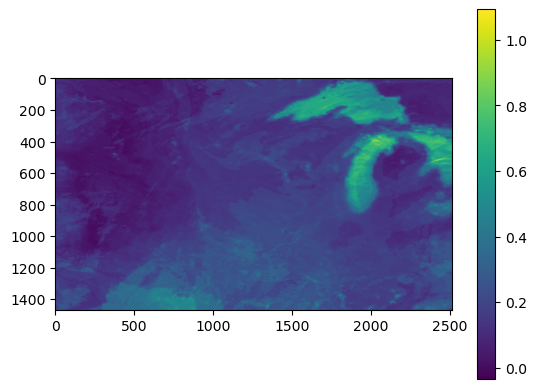

In [60]:
image = plt.imshow(ETs[0])
plt.colorbar(image)

In [61]:
np.save('./ET.npy', ETs[0]) #28MB

# Input Visuals

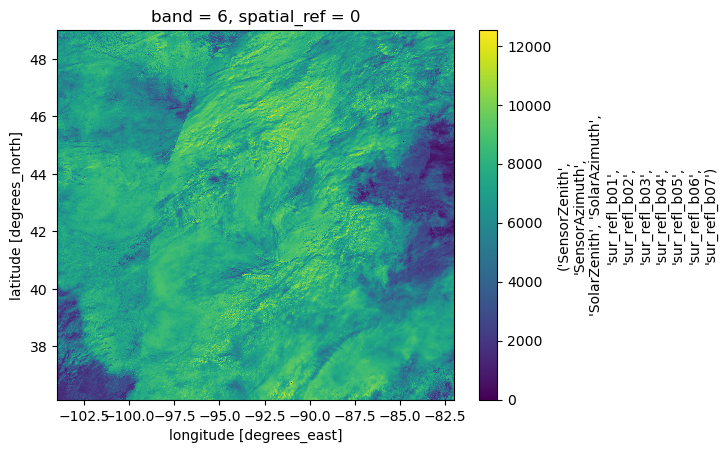

In [7]:
mod = rxr.open_rasterio('./data/MODIS_2020_76.tif', mask_and_scale=True).rio.reproject("EPSG:4326").sel(
            x=slice(bbox[0], bbox[2]),
            y=slice(bbox[3], bbox[1]),  
        )
mod.sel(band=6).plot()

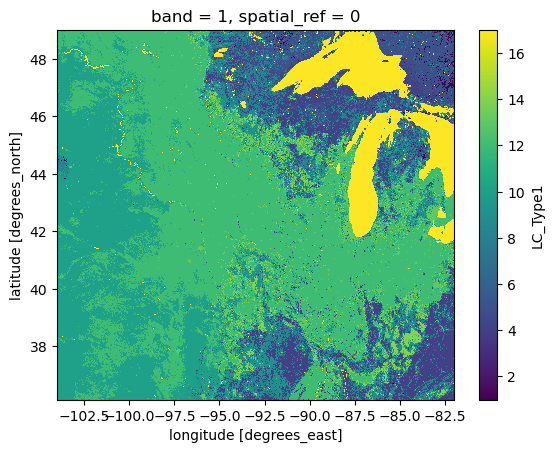

In [15]:
mod = rxr.open_rasterio('./data/MCD/MCD_2019_1.tif', mask_and_scale=True).rio.reproject("EPSG:4326").sel(
            x=slice(bbox[0], bbox[2]),
            y=slice(bbox[3], bbox[1]),  
        )
mod.sel(band=1).plot()

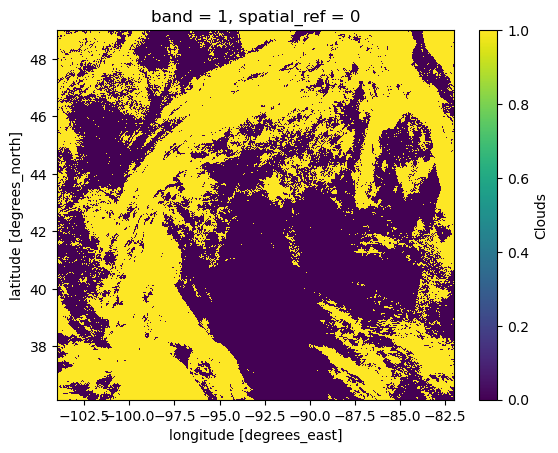

In [10]:
mod = rxr.open_rasterio('./data/MODIS Clouds/2018/MODIS_Clouds_2018_352.tif', mask_and_scale=True).rio.reproject("EPSG:4326").sel(
            x=slice(bbox[0], bbox[2]),
            y=slice(bbox[3], bbox[1]),  
        )
mod.sel(band=1).plot()

(-105.0, -80.0)

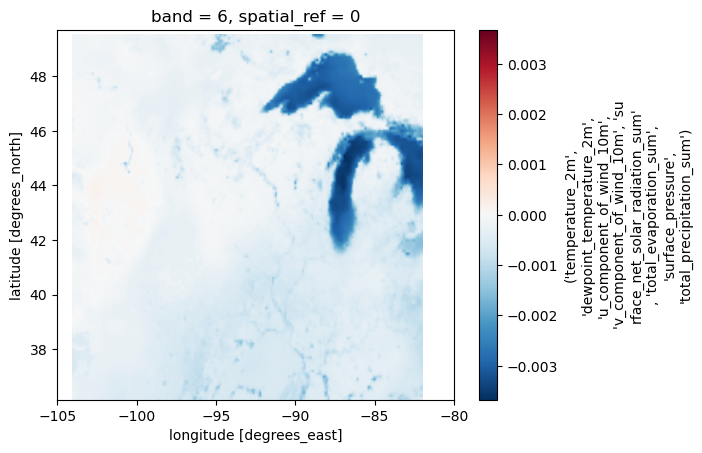

In [80]:
era.rio.reproject_match(mod, resampling=rasterio.enums.Resampling.bilinear).sel(band=6).plot()
plt.xlim(-105,-80)